# Kaggle Machine Learning Competition: BNP Paribas

![title](http://oi65.tinypic.com/2nvf248.jpg)

In [6]:
# Numerical Python and Pandas for data manipulation
import numpy as np
import pandas as pd

In [7]:
# Necessary libraries from Sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Imputer

In [8]:
# Visualization
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

In [9]:
# Algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import xgboost
from xgboost import plot_importance

In [10]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Import data set from Kaggle Competition "BNP Paribas" 

In [12]:
# Load CSV file
data = pd.read_excel("train_BNP_2.xlsx")

In [13]:
# Sneak peak into the dataset
data.head()

,ID,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v123,v124,v125,v126,v127,v128,v129,v130,v131,target
0,3,1.335739,8.727474,C,3.921026,7.915266,2.599278,3.176895,0.012941,9.999999,...,1.989780,0.035754,AU,1.804126,3.113719,2.024285,0,0.636365,2.857144,1
1,4,NaN,NaN,C,NaN,9.191265,NaN,NaN,2.301630,NaN,...,NaN,0.598896,AF,NaN,NaN,1.957825,0,NaN,NaN,1
2,5,0.943877,5.310079,C,4.410969,5.326159,3.979592,3.928571,0.019645,12.666667,...,2.477596,0.013452,AE,1.773709,3.922193,1.120468,2,0.883118,1.176472,1
3,6,0.797415,8.304757,C,4.225930,11.627438,2.097700,1.987549,0.171947,8.965516,...,1.812795,0.002267,CJ,1.415230,2.954381,1.990847,1,1.677108,1.034483,1
4,8,NaN,NaN,C,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Z,NaN,NaN,NaN,0,NaN,NaN,1


In [14]:
# Number of rows and columns
data.shape

(114321, 133)

In [15]:
# view number of elements (rows * columns)
data.size

15204693

In [16]:
# number of dimensions
data.ndim

2

# Class Distribution

In [17]:
# How target/label distributed? Balanced?
target_counts = data.groupby('target').size()
target_counts

target
0    27300
1    87021
dtype: int64

In [18]:
# Perecentage?
def percentage(part, whole):
  return 100 * float(part)/float(whole)
percentage(2396, 7604)

31.50973172014729

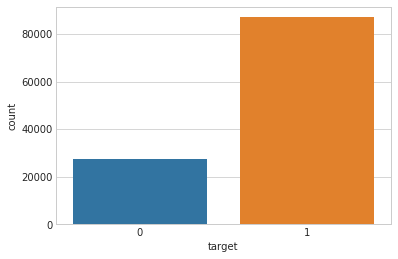

In [19]:
# Target/label visualized
sns.countplot(x="target", data=data)

# Outliers
What to do with outliers is an open and very difficult question. In general, if the outliers represent <5% of the dataset, we might ignore (remove) them. But the outliers represent >5%, they are probably not outliers anymore, but are part of the nature of the dataset. 

The MinMaxScaler is very sensitive to the presence of outliers. Including them would very likely effect the predictive power of this feature.

Practicioner: be aware of outliers, but don't do anything unless really necessary. In general, Logistic Regression and Decision Trees can deal with outliers. For example, the outlier effect on the dataset Titanic in accuracy and ROC is neglectable (see Notebook by Soledad Galli).

Text(0, 0.5, 'v11')

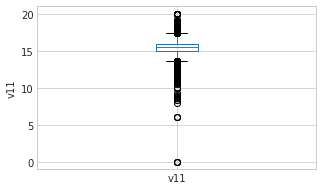

In [20]:
# let's make boxplots to visualise outliers in the continuous variables 

plt.figure(figsize=(11,3))
plt.subplot(1, 2, 1)
fig = data.boxplot(column='v11')
fig.set_title('')
fig.set_ylabel('v11')

Text(0.5, 0, 'ID')

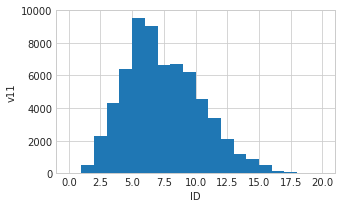

In [21]:
# first we plot the distributions to find out if they are Gaussian or skewed.

plt.figure(figsize=(11,3))
plt.subplot(1, 2, 1)
fig = data.v2.hist(bins=20)
fig.set_ylabel('v11')
fig.set_xlabel('ID')

In [22]:
# let's look at the values of the quantiles so we can

data.v11.describe()

count    6.448500e+04
mean     1.544741e+01
std      7.900790e-01
min     -1.459062e-07
25%      1.500000e+01
50%      1.549595e+01
75%      1.595000e+01
max      2.000000e+01
Name: v11, dtype: float64

In [23]:
# Let's calculate the upper and lower boundaries

IQR = data.v11.quantile(0.75) - data.v11.quantile(0.25)

Lower_fence = data.v11.quantile(0.25) - (IQR * 1.5)
Upper_fence = data.v11.quantile(0.75) + (IQR * 1.5)

Upper_fence, Lower_fence, IQR

(17.374998324849997, 13.575001876450003, 0.9499991120999987)

# Cardinality
Cardinality, where one category dominates, can be a problem for an algorithm such as Random Forest, which can lead to favoring the major feature. 

There are different methods in dealing cardinality such as one-hot encoding or hashing, but the simplest trick is count or frequency encoding. This approach is heavily used in Kaggle competitions. The count approach is the amount of times each label appears in the dataset. The frequency approach is the percentage of observations within that category.

In [24]:
# types of variables
data.dtypes.head(5)

ID      int64
v1    float64
v2    float64
v3     object
v4    float64
dtype: object

In [25]:
# find categorical variables
categorical = [var for var in data.columns if data[var].dtype=='O']
print('There are {} categorical variables'.format(len(categorical)))

There are 19 categorical variables


In [26]:
# find numerical variables
numerical = [var for var in data.columns if data[var].dtype!='O']
print('There are {} numerical variables'.format(len(numerical)))

There are 114 numerical variables


# Labels that occur rarely
Categorical variables in business datasets very often contain a few dominant labels that account for the majority of the observations and a large number of labels that appear only seldomly.

In [27]:
# let's check the different number of labels withing each variable
cols_to_use = ['v3','v22','v24','v30','v31','v47','v52','v56','v66','v71','v74','v75','v79','v91','v107','v110',
               'v112','v113','v125']

for col in cols_to_use:
    print('variable: ', col, ' number of labels: ', len(data[col].unique()))

variable:  v3  number of labels:  4
variable:  v22  number of labels:  18211
variable:  v24  number of labels:  5
variable:  v30  number of labels:  8
variable:  v31  number of labels:  4
variable:  v47  number of labels:  10
variable:  v52  number of labels:  13
variable:  v56  number of labels:  123
variable:  v66  number of labels:  3
variable:  v71  number of labels:  9
variable:  v74  number of labels:  3
variable:  v75  number of labels:  4
variable:  v79  number of labels:  18
variable:  v91  number of labels:  8
variable:  v107  number of labels:  8
variable:  v110  number of labels:  3
variable:  v112  number of labels:  23
variable:  v113  number of labels:  37
variable:  v125  number of labels:  91


# Nominal Feature Encoding of Categories
Technically not perfect, but I will only encode categorical features, not hot-encode. Reasons are (1) small difference between only encoding and encoding + hot encoding and (2) replication in Tableau.

In [28]:
cols_to_transform = ['v3','v22','v24','v30','v31','v47','v52','v56','v66','v71','v74','v75','v79',
                     'v91','v107','v110','v112','v113','v125']

In [29]:
data_cat = pd.get_dummies(data = cols_to_transform)

In [30]:
# get_dummies is ONE HOT ENCODING !!! Better keep categorical for Decision Tree?

# Concatenating Categorical + Numerical Data in Pandas

In [31]:
X = data._get_numeric_data()

In [32]:
# Concatenate Numerical + Categorical (encoded) data
X2 = pd.concat([X,data_cat], axis=1)

In [33]:
X2.fillna(X2.median(), inplace=True)

In [34]:
X2.drop(['ID', 'target'], axis=1, inplace=True)

In [35]:
y = data['target']

# Feature Scaling
I will not apply MinMaxScaler (0-1) or Standardize (mean 0 with 1 standard deviation). The reasons for this is (1) outliers are a natural occurence in our dataset (2) without removing outliers we impact MinMaxScaler badly and (3) in almost all cases, Logistic Regression and Decision Tree works well without normalizing or standardizing.

# Split Data into Training and Test Sets

In [37]:
validation_size = 0.2
seed = 12
X_train, X_test, y_train, y_test, = train_test_split(X2, y, test_size=validation_size, random_state=seed)

In [38]:
num_fold = 10
kfold = KFold(n_splits=10, random_state=12)
seed = 12 

# Machine Learning Algorithm

In [39]:
model = DecisionTreeClassifier(criterion='gini', splitter='best',
                               max_depth=10, min_samples_split=2,
                               min_samples_leaf=1, min_weight_fraction_leaf=0.0,
                               max_features=None, random_state=seed, 
                               max_leaf_nodes=10, min_impurity_decrease=0.0,
                               min_impurity_split=None, class_weight="balanced", presort=False)

# max_leaf_notes = 10 seems to work fine and has a low risk of overfitting

In [40]:
model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=10, max_features=None, max_leaf_nodes=10,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=12,
            splitter='best')

# K-fold Cross-Validation
The choice of k must allow the size of each test partition to be large enough to be a reasonable sample of the problem, whilst allowing enough repetitions of the train-test evaluation of the algorithm to provide a fair estimate of the algorithms performance on unseen data. In the example below we use 10-fold cross-validation:

In [41]:
num_folds = 3
seed = 12

kfold = KFold(n_splits=num_folds, random_state=seed)
results = cross_val_score(model, X_test, y_test, cv=kfold)
print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))

Accuracy: 63.849% (2.777%)


# Confusion Matrix
The confusion matrix is a handy presentation of the accuracy of a model with two or more classes. The table presents predictions on the x-axis and accuracy outcomes on the y-axis. The cells of the table are the number of predictions made by a machine learning algorithm. For example, a machine learning algorithm can predict 0 or 1 and each prediction may actually have been a 0 or 1. Predictions for 0 that were actually 0 appear in the cell for prediction = 0 and actual = 0, whereas predictions for 0 that were actually 1 appear in the cell for prediction = 0 and actual = 1. And so on.

In [42]:
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

In [43]:
from sklearn.metrics import classification_report
predicted = model.predict(X_test)
report = classification_report(y_test, predicted)
print(report)

              precision    recall  f1-score   support

           0       0.38      0.63      0.48      5617
           1       0.85      0.67      0.75     17248

   micro avg       0.66      0.66      0.66     22865
   macro avg       0.62      0.65      0.61     22865
weighted avg       0.73      0.66      0.68     22865



# Area Under ROC Curve
Area under ROC Curve (or AUC for short) is a performance metric for binary classification problems. The AUC represents a model's ability to discriminate between positive and negative classes. An area of 1.0 represents a model that made all predictions perfectly. An area of 0.5 represents a model that is as good as random. ROC can be broken down into sensitivity and specificity. A binary classification problem is really a trade-off between sensitivity and specificity.

- Sensitivity is the true positive rate also called the recall. It is the number of instances from the positive (first) class that actually predicted correctly.

- Specificity is also called the true negative rate. Is the number of instances from the negative (second) class that were actually predicted correctly.

The example below provides a demonstration of calculating AUC.

In [44]:
scoring = 'roc_auc'
results = cross_val_score(model, X2, y, cv=kfold, scoring=scoring)
print("AUC: %.3f (%.3f)" % (results.mean(), results.std()))

AUC: 0.695 (0.002)


# Visualizing the Learning Curve

In [45]:
from sklearn.model_selection import learning_curve

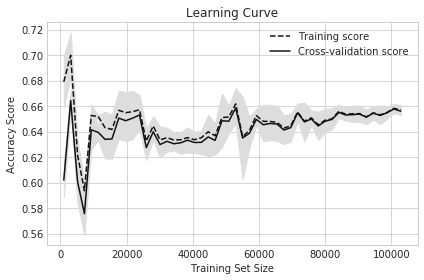

In [46]:
# Create CV training and test scores for various training set sizes
train_sizes, train_scores, test_scores = learning_curve(DecisionTreeClassifier(criterion='gini', splitter='best',
                               max_depth=None, min_samples_split=2,
                               min_samples_leaf=1, min_weight_fraction_leaf=0.0,
                               max_features=None, random_state=seed, 
                               max_leaf_nodes=10, min_impurity_decrease=0.0,
                               min_impurity_split=None, class_weight="balanced", presort=False), 
                                                        X2, 
                                                        y,
                                                        # Number of folds in cross-validation
                                                        cv=10,
                                                        # Evaluation metric
                                                        scoring='accuracy',
                                                        # Use all computer cores
                                                        n_jobs=-1, 
                                                        # 50 different sizes of the training set
                                                        train_sizes=np.linspace(0.01, 1.0, 50))

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

# Feature Importance with XGBoost
Using XGBoost, we can measure the feature importance as the averaged impuritiy (Gini) decrease computed from all decision trees in the forst, without making any assumptions about whether our data is linearly seperable or not. It's not without dangers (correlation, cardinality...), but for a practionar, it's probably the most robust feature selection technique.

In [47]:
# fit the model to the training data
model2 = XGBClassifier()

In [48]:
model2.fit(X_train, y_train, eval_metric=None, eval_set=[(X_train, y_train)], verbose=False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [49]:
# make predictions for test data
y_pred = model2.predict(X_test)
predictions2 = [round(value) for value in y_pred]

In [50]:
# evaluate predictions
accuracy = accuracy_score(y_test, predictions2)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 76.52%


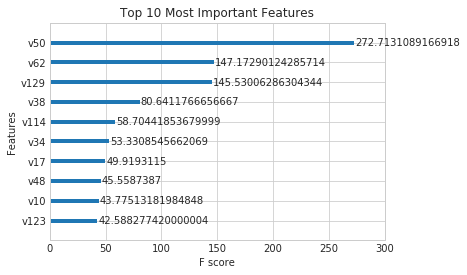

In [51]:
xgboost.plot_importance(model2, importance_type="gain", max_num_features=10)
plt.title('Top 10 Most Important Features')
plt.show()

# Visualizing the Decision Tree

In [52]:
columns = X2.columns.values.tolist()

In [53]:
dot_data = StringIO()
export_graphviz(
    model,
    out_file=dot_data, 
    filled=True,
    rounded=True,
    feature_names=columns,
    class_names=['Low Risk','High Risk'],
    special_characters=True)

In [54]:
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

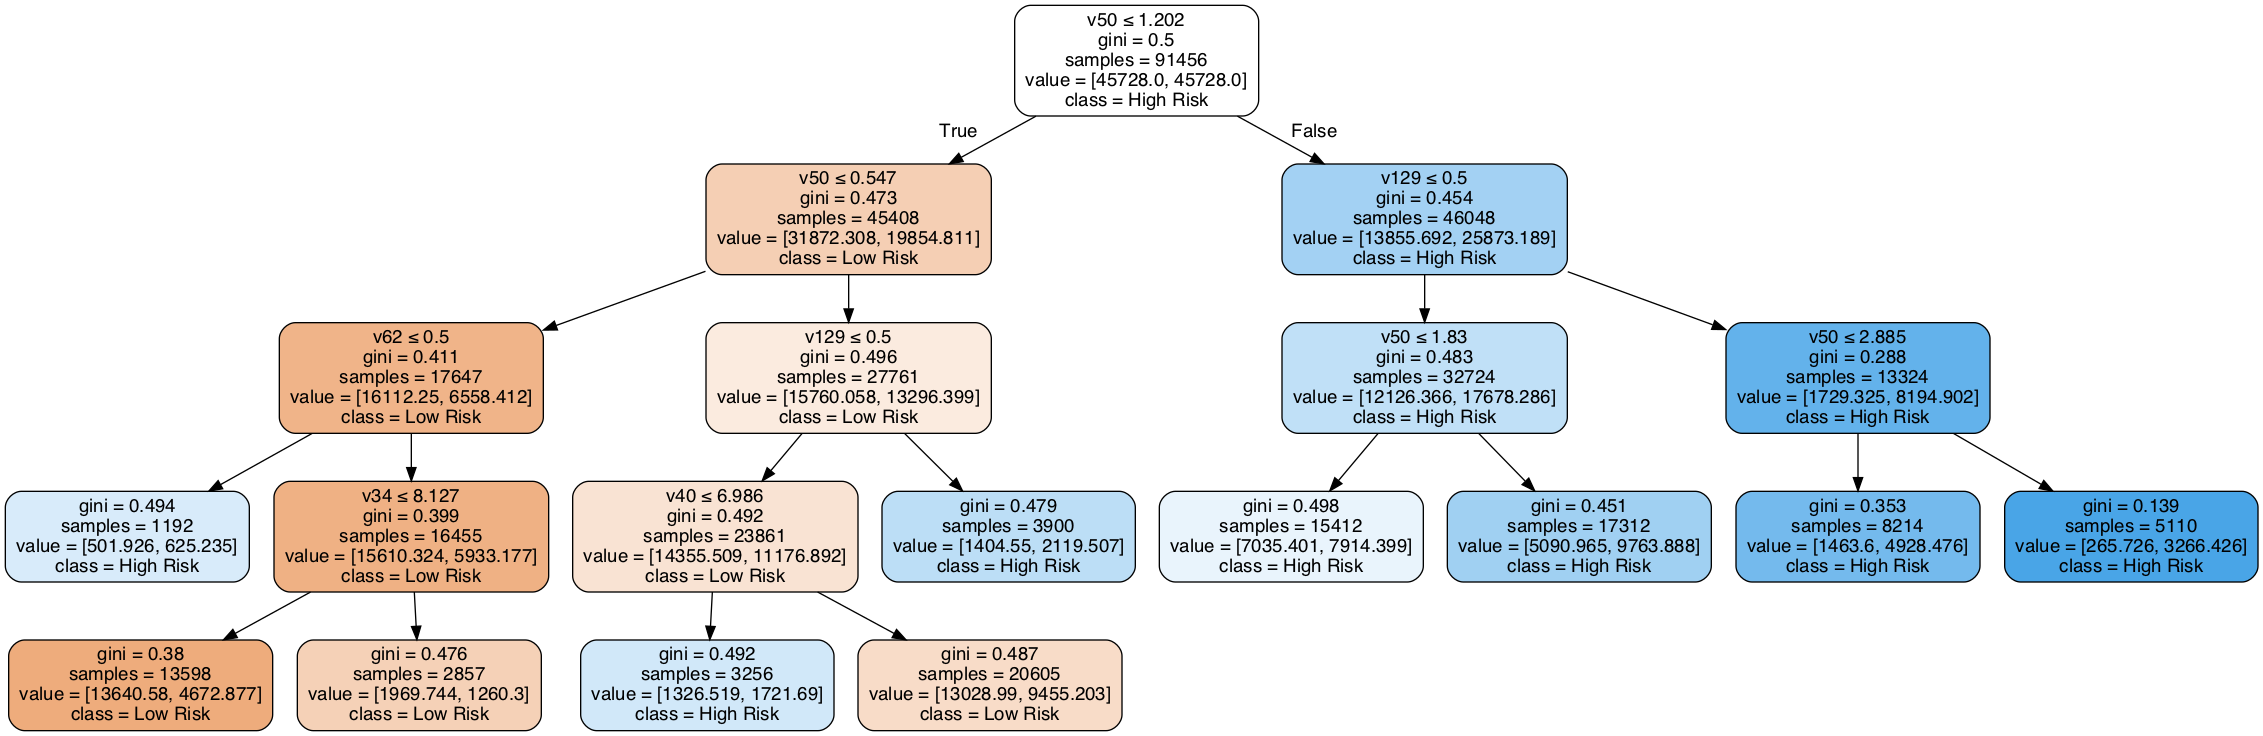

In [55]:
Image(graph.create_png())

# Log Loss Score
Log loss, also called “logistic loss,” “logarithmic loss,” or “cross entropy” can be used as a measure for evaluating predicted probabilities.

Each predicted probability is compared to the actual class output value (0 or 1) and a score is calculated that penalizes the probability based on the distance from the expected value. The penalty is logarithmic, offering a small score for small differences (0.1 or 0.2) and enormous score for a large difference (0.9 or 1.0).

A model with perfect skill has a log loss score of 0.0

In [58]:
from sklearn.metrics import log_loss

# predict probabilities
probs = model.predict_proba(X_test)
# keep the predictions for class 1 only
probs = probs[:, 1]
# calculate log loss
loss = log_loss(y_test, probs)

In [59]:
loss

0.6251877543148388

# Conclusion

- With max_leaf_nodes = 10, our Decision Tree has a good Precision/Recall while unlikely to overfit.
- The feature v50 strongly dominates, which gives us a good Recall.
- We did not do any feature engineering (e.g. manually combine features, binning, create non-linear features...) 
- Log loss of 0.625 would put us in the 50th percentile in the Kaggle competition.
- Kaggle winner log loss is around 0.49 with heavy feature engineering / XGBoost.

In a Kaggle competition, this model would not be able to win. 

But this model should be very robust and scalable in the real-world.